# Comparing Worldwide Cities by Popular Venues

In [1]:
!pip3 install bs4

You should consider upgrading via the 'c:\users\nick\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

First we will extract the top cities worldwide by population for a wikipedia article

In [3]:
url = 'https://en.m.wikipedia.org/wiki/List_of_largest_cities#List'
table = requests.get(url)
soup = BeautifulSoup(table.text,'html.parser')

In [4]:
#Extracting just city name, country and area of city proper (all that is needed for this analysis)
table_contents = []
table = soup.find('table')
#13 rows for each entry
count = 0
cell = {}
for row in table.findAll('td'):
    if count == 0:
        cell['City'] = row.text.rstrip('\n')
    elif count == 1:
        cell['Country'] = row.text
    elif count == 6:
        cell['Area'] = row.text.rstrip()
        table_contents.append(cell)
        
    count += 1
    
    if count == 14:
        count = 0
        cell = {}
            
cities_df = pd.DataFrame(table_contents)
cities_df['Country'] = cities_df['Country'].apply(lambda x : str(x).split('\n')[0])
cities_df['Country'] = cities_df['Country'].apply(lambda x : str(x).split('(more)')[0])

In [5]:
#Now take only one city per country
cities_df = cities_df.drop_duplicates(subset=['Country']).reset_index(drop=True)
cities_df

,City,Country,Area
0,Tokyo,Japan,"2,191"
1,Delhi,India,"1,484"
2,Seoul,South Korea,605
3,Shanghai,China,"6,341"
4,São Paulo,Brazil,"1,521"
5,Mexico City,Mexico,"1,485"
6,Cairo,Egypt,"3,085"
7,Dhaka,Bangladesh,338
8,New York,United States,786
9,Karachi,Pakistan,"3,530"


In [6]:
cities_df.shape

(36, 3)

Now we will acquire each city's coordinates

In [7]:
!pip3 install geopy

You should consider upgrading via the 'c:\users\nick\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [8]:
from geopy.geocoders import Nominatim

In [9]:
# Getting the coordinates of each city
geolocator = Nominatim(user_agent='Comparing-Venues')
locs = []
for city, country in zip(cities_df['City'],cities_df['Country']):
    cell = {}
    loc = geolocator.geocode(str(city + ' , ' + country))
    try:
        cell['Latitude'] = loc.latitude
        cell['Longitude'] = loc.longitude
    except:
        cell['Latitude'] = 'NA'
        cell['Longitude'] = 'NA'
    locs.append(cell)
cities_df = cities_df.join(pd.DataFrame(locs))
cities_df.head()

,City,Country,Area,Latitude,Longitude
0,Tokyo,Japan,"2,191",35.682839,139.759455
1,Delhi,India,"1,484",28.651718,77.221939
2,Seoul,South Korea,605,37.566679,126.978291
3,Shanghai,China,"6,341",31.232276,121.469207
4,São Paulo,Brazil,"1,521",-23.550651,-46.633382


We will now map the cities

In [10]:
!pip3 install folium

You should consider upgrading via the 'c:\users\nick\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [11]:
import folium

In [12]:
# create world map of the cities using latitude and longitude values
world_map = folium.Map(location=[0, 0], zoom_start=2)

# add markers to map
for lat, lng, label in zip(cities_df['Latitude'], cities_df['Longitude'], cities_df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(world_map)  
    
world_map

Now we will get location data using Foursquare.

In [13]:
# @hidden_cell
CLIENT_ID = 'JME32Z00YTSH4FSLUFZSWAQSGCHNEC1HX30SY2Q1N5U2ET4L' # your Foursquare ID
CLIENT_SECRET = '1INNJVMJHDXIULGM0GAKE1DJCTM4EKDBAYA2LEA2I4F11PJG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [14]:
#if Area is N/A in dataframe, replace with average area and change to integer
cities_df['Area'] = cities_df['Area'].apply(lambda x : x.replace(',',''))
temp_df = cities_df[cities_df.Area != 'N/A']
avg = pd.to_numeric(temp_df['Area'])
avg = int((avg.mean()))
cities_df['Area'] = cities_df['Area'].replace('N/A',avg)

Now we will calculate the radius used, which will simply be r = sqrt(A/pi)*100     (The measurments are in Km and we want meters)

In [33]:
cities_df['Area'] = cities_df['Area'].apply(lambda x : float(x))
cities_df['Radius'] = round(np.sqrt(cities_df['Area']//np.pi) * 100)

In [14]:
cities_df['Area'] = cities_df['Area'].apply(lambda x : float(x))
cities_df['Radius'] = round(np.sqrt(cities_df['Area']//np.pi) * 100)

In [34]:
cities_df

,City,Country,Area,Latitude,Longitude,Radius
0,Tokyo,Japan,2191.0,35.682839,139.759455,2640.0
1,Delhi,India,1484.0,28.651718,77.221939,2173.0
2,Seoul,South Korea,605.0,37.566679,126.978291,1386.0
3,Shanghai,China,6341.0,31.232276,121.469207,4492.0
4,São Paulo,Brazil,1521.0,-23.550651,-46.633382,2200.0
5,Mexico City,Mexico,1485.0,19.432630,-99.133178,2173.0
6,Cairo,Egypt,3085.0,30.044388,31.235726,3132.0
7,Dhaka,Bangladesh,338.0,23.810651,90.412647,1034.0
8,New York,United States,786.0,40.712728,-74.006015,1581.0
9,Karachi,Pakistan,3530.0,24.854684,67.020706,3351.0


In [35]:
# getting the set of top level categories in the Foursquare hierarchy
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET,
                VERSION)
results = requests.get(url)
r = results.json()["response"]

In [36]:
# The set of top level categories will be banned. Adding 'Asian Restaurant' by hand.
banned_set = set()
name_index = {}
for row in r['categories']:
    banned_set.add(row['id'])
    name_index[row['name']] = row['id']
banned_set.add('4bf58dd8d48988d142941735')
name_index['Asian Restaurant'] = '4bf58dd8d48988d142941735'

In [37]:
# function to extract next level category. Categories are too broad, so need the hierarchy in order to determine proper types. Also fills the name_index dictionary to link names to category IDs.
hierarchy = {}
index_name = {}
def recurse_hierarchy(r):
    for di in r.keys():
        if di == 'categories':
            for k in r[di]:
                hierarchy[k['id']] = r['id']
                name_index[k['name']] = k['id']
            for k in r[di]:
                recurse_hierarchy(k)                    

for di in r['categories']:
    recurse_hierarchy(di)
for i in name_index:
    index_name[name_index[i]] = i

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

This will retrieve the top 50 venues by popularity for each of the cities

In [40]:
# function to get the venues near the city, currently set to the first 150 venues by popularity with a radius proportional to the area of the city. Running twice for extra results.
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        offset = 0
        for i in range(3):
            print(name)
            obtained = set()
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}&sortByPopularity={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                rad,
                LIMIT,
                offset,
                1)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results if v['venue']['name'] not in obtained])
            # don't want duplicate results
            for v in results:
                obtained.add(v['venue']['name'])
            offset = 50 * i
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
world_venues = getNearbyVenues(names=cities_df['City'],
                                   latitudes=cities_df['Latitude'],
                                   longitudes=cities_df['Longitude'],
                                   radius = cities_df['Radius']
                                  )

Tokyo
Tokyo
Tokyo
Delhi
Delhi
Delhi
Seoul
Seoul
Seoul
Shanghai
Shanghai
Shanghai
São Paulo
São Paulo
São Paulo
Mexico City
Mexico City
Mexico City
Cairo
Cairo
Cairo
Dhaka
Dhaka
Dhaka
New York
New York
New York
Karachi
Karachi
Karachi
Buenos Aires
Buenos Aires
Buenos Aires
Istanbul
Istanbul
Istanbul
Manila
Manila
Manila
Lagos
Lagos
Lagos
Kinshasa
Kinshasa
Kinshasa
Moscow
Moscow
Moscow
Paris
Paris
Paris
Bogotá
Bogotá
Bogotá
Jakarta
Jakarta
Jakarta
Lima
Lima
Lima
Bangkok
Bangkok
Bangkok
London
London
London
Tehran
Tehran
Tehran
Ho Chi Minh City
Ho Chi Minh City
Ho Chi Minh City
Luanda
Luanda
Luanda
Kuala Lumpur
Kuala Lumpur
Kuala Lumpur
Riyadh
Riyadh
Riyadh
Baghdad
Baghdad
Baghdad
Santiago
Santiago
Santiago
Madrid
Madrid
Madrid
Toronto
Toronto
Toronto
Dar es Salaam
Dar es Salaam
Dar es Salaam
Singapore
Singapore
Singapore
Khartoum
Khartoum
Khartoum
Johannesburg
Johannesburg
Johannesburg
Yangon
Yangon
Yangon


In [42]:
world_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tokyo,35.682839,139.759455,Yodobashi-Akiba (ヨドバシカメラ マルチメディアAkiba),35.698713,139.774761,Electronics Store
1,Tokyo,35.682839,139.759455,Imperial Palace (皇居),35.682500,139.752100,Palace
2,Tokyo,35.682839,139.759455,Keiyō Line Tōkyō Station (京葉線 東京駅),35.677727,139.764848,Train Station
3,Tokyo,35.682839,139.759455,Kanda Myojin Shrine (神田明神),35.701733,139.767714,Shrine
4,Tokyo,35.682839,139.759455,AKB48 Theater (AKB48劇場),35.700676,139.771741,Theater
...,...,...,...,...,...,...,...
8479,Yangon,16.796713,96.160992,Ice Cream Bar,16.806491,96.145233,Ice Cream Shop
8480,Yangon,16.796713,96.160992,Shwe Kaung Hot Pot,16.802186,96.157418,Hotpot Restaurant
8481,Yangon,16.796713,96.160992,Health Club,16.778746,96.158353,Gym / Fitness Center
8482,Yangon,16.796713,96.160992,Beauty Concept,16.806531,96.146929,Spa


In [48]:
# Remove hotels & hostel category.
world_venues = world_venues[(world_venues['Venue Category'] != 'Hotel') & (world_venues['Venue Category'] != 'Hostel')]
world_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tokyo,35.682839,139.759455,Yodobashi-Akiba (ヨドバシカメラ マルチメディアAkiba),35.698713,139.774761,Electronics Store
1,Tokyo,35.682839,139.759455,Imperial Palace (皇居),35.682500,139.752100,Palace
2,Tokyo,35.682839,139.759455,Keiyō Line Tōkyō Station (京葉線 東京駅),35.677727,139.764848,Train Station
3,Tokyo,35.682839,139.759455,Kanda Myojin Shrine (神田明神),35.701733,139.767714,Shrine
4,Tokyo,35.682839,139.759455,AKB48 Theater (AKB48劇場),35.700676,139.771741,Theater
...,...,...,...,...,...,...,...
8479,Yangon,16.796713,96.160992,Ice Cream Bar,16.806491,96.145233,Ice Cream Shop
8480,Yangon,16.796713,96.160992,Shwe Kaung Hot Pot,16.802186,96.157418,Hotpot Restaurant
8481,Yangon,16.796713,96.160992,Health Club,16.778746,96.158353,Gym / Fitness Center
8482,Yangon,16.796713,96.160992,Beauty Concept,16.806531,96.146929,Spa


The categories could be too broad. There are around 400 different categories. We will apply a funciton to the category type to get less broad categories.

In [49]:
def generalize(x):
    try:
        if hierarchy[name_index[x]] not in banned_set:
            return index_name[hierarchy[name_index[x]]]
        else:
            return x
    except:
        return x

In [50]:
world_venues_general = world_venues.copy()
world_venues_general['Venue Category'] = world_venues_general['Venue Category'].apply(lambda x : generalize(x))

Going forward, there will be two datasets discussed. First, the non-generalized set will be modified and analyzed

In [51]:
# one hot encoding
world_onehot = pd.get_dummies(world_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
world_onehot['City'] = world_venues['City']

# move city column to the first column
fixed_columns = [world_onehot.columns[-1]] + list(world_onehot.columns[:-1])
world_onehot = world_onehot[fixed_columns]

world_onehot.head()

,City,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant
0,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# one hot encoding
world_onehot_general = pd.get_dummies(world_venues_general[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
world_onehot_general['City'] = world_venues_general['City']

# move city column to the first column
fixed_columns = [world_onehot_general.columns[-1]] + list(world_onehot_general.columns[:-1])
world_onehot_general = world_onehot_general[fixed_columns]

world_onehot_general.head()

,City,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,...,University,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wings Joint
0,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
world_grouped = world_onehot.groupby('City').sum()
world_grouped_general = world_onehot_general.groupby('City').sum()

## Exploratory Analysis - Set 1: Non-Generalized Venue Categories

Now we will perform some exploratory analysis in order to better understand the data and trends. We previously found the counts for each venue type in each city. Now we will compare each cities most popular venue type.

In [54]:
pop_graph = pd.DataFrame()
pop_graph['Most Popular'] = world_grouped.idxmax(axis=1)
pop_graph['Count'] = world_grouped.max(axis=1)
pop_graph

,Most Popular,Count
City,,
Baghdad,Café,22
Bangkok,Noodle House,66
Bogotá,Burger Joint,16
Buenos Aires,Pizza Place,19
Cairo,Café,37
Dar es Salaam,BBQ Joint,9
Delhi,Indian Restaurant,44
Dhaka,Café,6
Ho Chi Minh City,Vietnamese Restaurant,37


Next, we will compare the distribution of popular venue types for several cities of different sizes in order to gauge similarities. In this case: Tokyo (Asia), London (Europe), & Dar es Salaam (Africa)

In [55]:
world_grouped = world_grouped.reset_index()
tokyo = world_grouped.loc[world_grouped['City'] == 'Tokyo']

In [56]:
london = world_grouped.loc[world_grouped['City'] == 'London']
des = world_grouped.loc[world_grouped['City'] == 'Dar es Salaam']
df = tokyo.append(london).append(des)
#drop column if all values are 0
df = df.loc[:, (df != 0).any(axis=0)]
df

,City,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Trail,Train Station,Udon Restaurant,Unagi Restaurant,Wagashi Place,Wine Bar,Wine Shop,Women's Store,Yoshoku Restaurant
33,Tokyo,0,1,2,0,5,0,1,3,1,...,0,5,2,9,1,3,0,0,0,8
18,London,0,0,0,1,8,2,0,10,3,...,3,0,0,0,0,0,2,1,1,0
5,Dar es Salaam,4,2,0,0,0,4,9,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

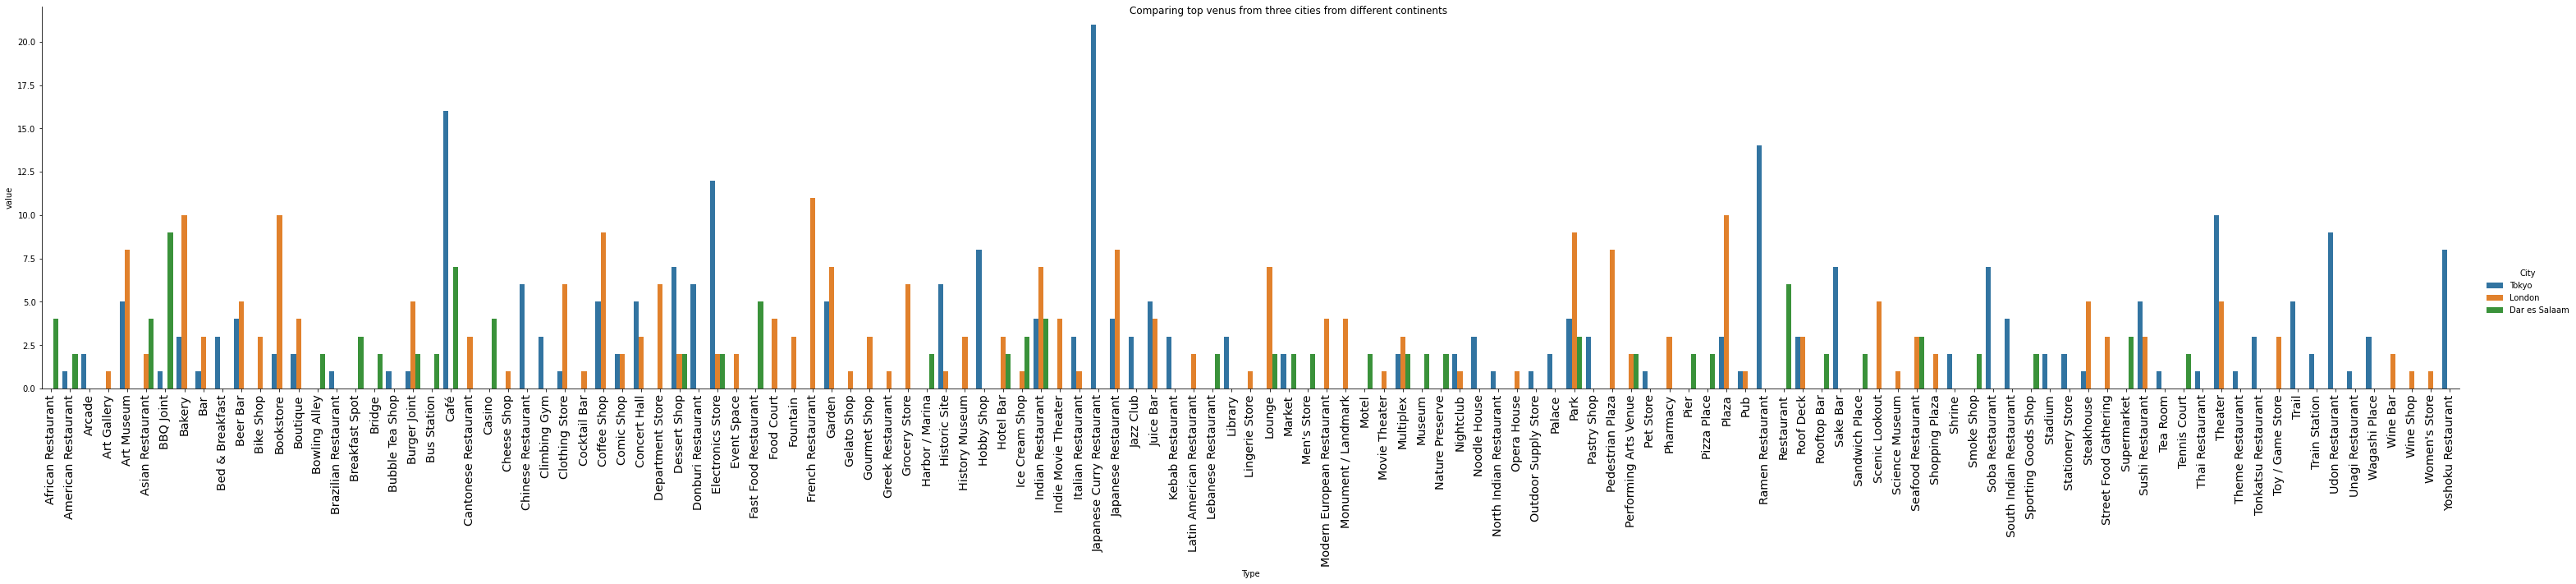

In [58]:
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus from three cities from different continents')

Next, we will compare two cities from the same continent. We will look at Buenos Aires, Argentina & Santiago, Chile from South America.

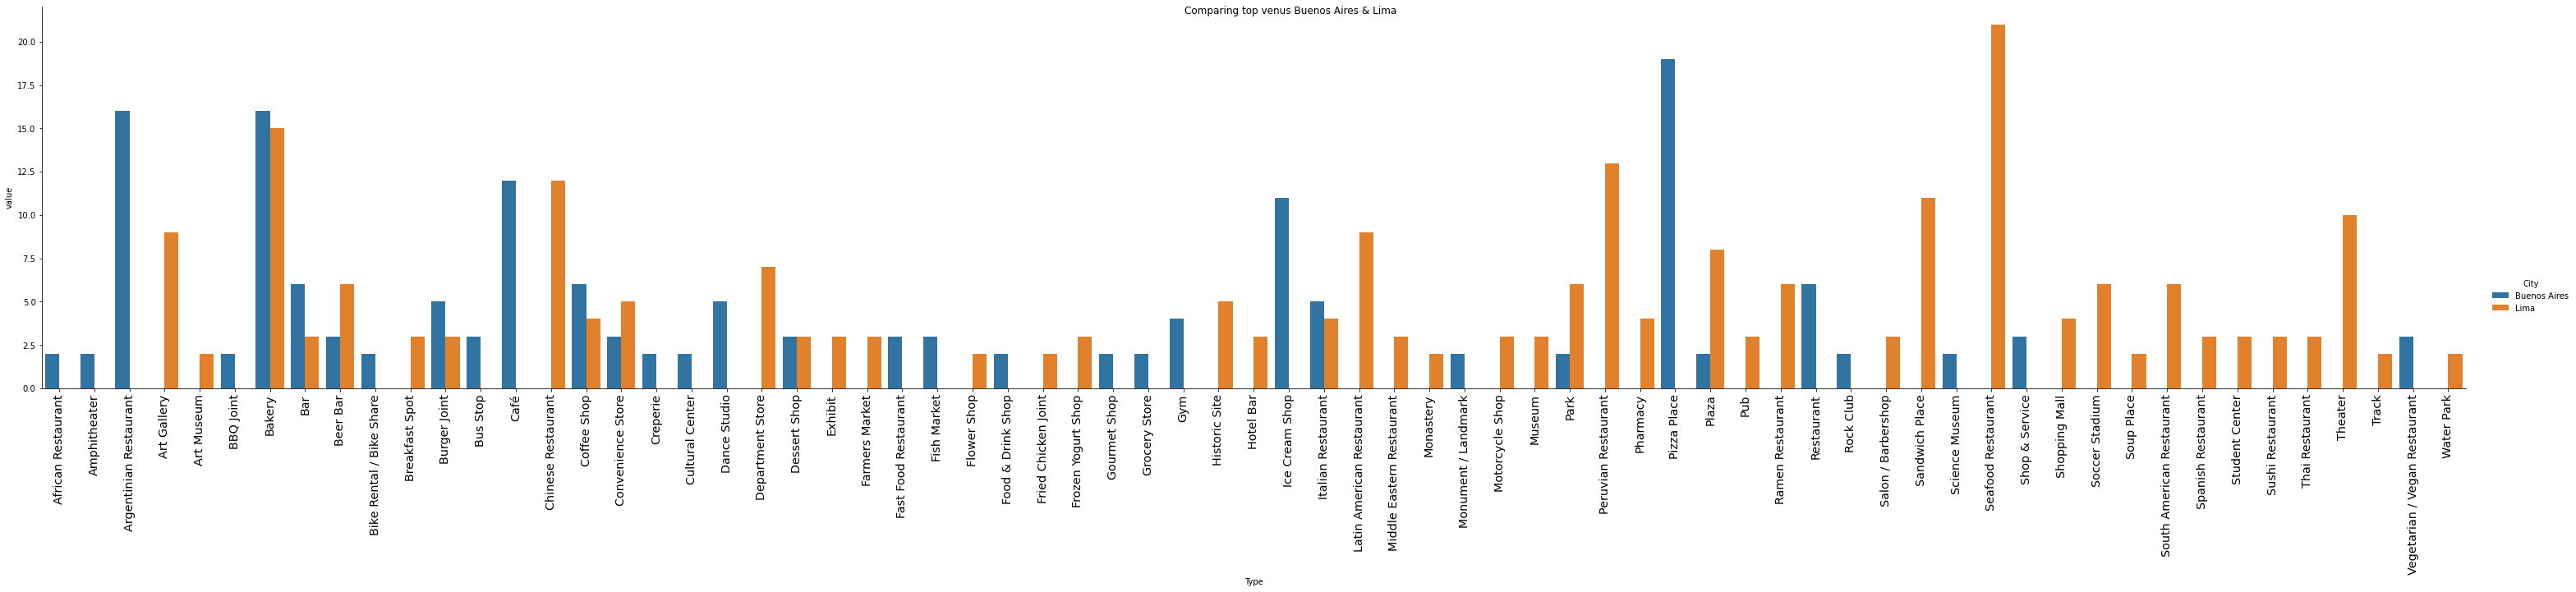

In [59]:
ba = world_grouped.loc[world_grouped['City'] == 'Buenos Aires']
s = world_grouped.loc[world_grouped['City'] == 'Lima']
df = ba.append(s)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus Buenos Aires & Lima')

Finally, we will compare a coastal city (Shanghai, China) to an inland city (Madrid, Spain)

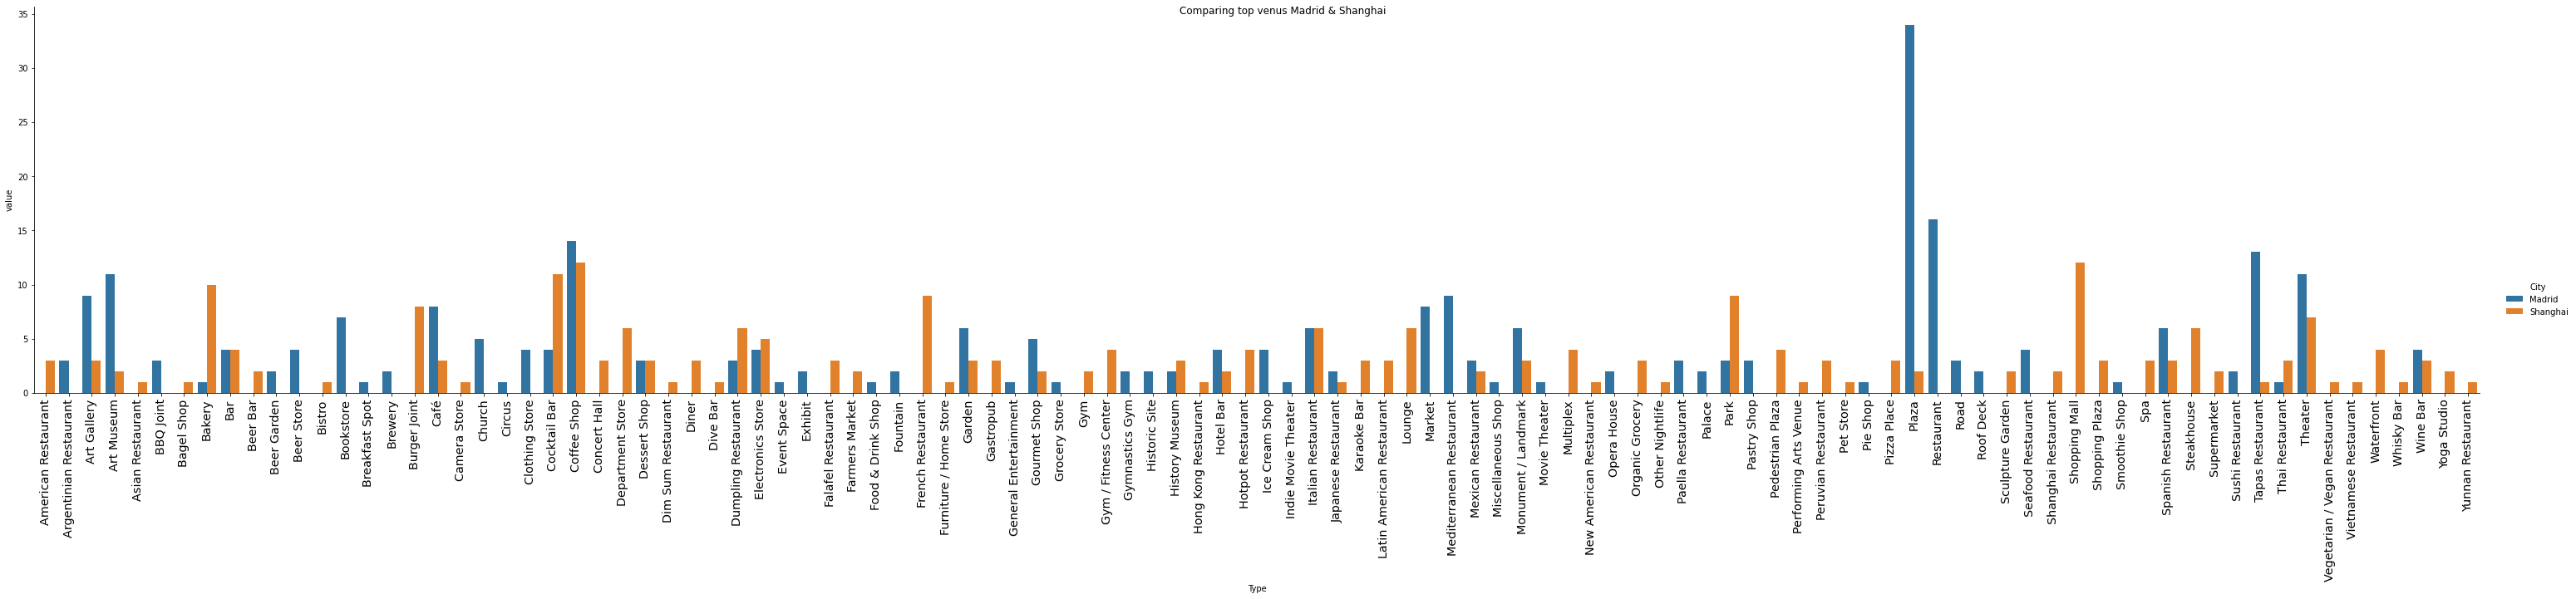

In [60]:
m = world_grouped.loc[world_grouped['City'] == 'Madrid']
j = world_grouped.loc[world_grouped['City'] == 'Shanghai']
df = m.append(j)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus Madrid & Shanghai')

# K-Means Clustering - Set 1: Non-Generalized Venue Categories

Now we will use K-means clustering to determine which cities are most similar. We will also determine the optimal K.

In [61]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [62]:
# Get percentages for each venue type in each city
df_ml = world_onehot.groupby('City').mean().reset_index()
df_ml = df_ml.drop('City',1)
df_ml

,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.027586,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.003413,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010239,0.003413,0.00000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.012270,0.000000,0.000000,0.000000,0.01227,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.011070,0.000000,0.000000,0.000000,0.000000,0.000000,0.01107,0.000000,0.00000,0.000000
5,0.000000,0.000000,0.037037,0.000000,0.000000,0.018519,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.003636,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000


In [103]:
# using the intertia attribute of the Kmeans object, we can find the optimal K
ssd = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ml)
    ssd.append(km.inertia_)

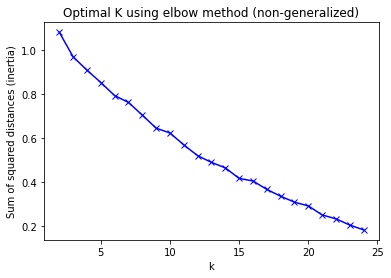

In [104]:
# Now we plot the sum of squared distances (inertia) and find the elbow
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (inertia)')
plt.title('Optimal K using elbow method (non-generalized)')
plt.show()

Next, we will try the silhouette score to determine the optimal K value

In [105]:
ss = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ml)
    
    s_avg = metrics.silhouette_score(df_ml, km.labels_)
    print("For K clusters:", k, "The average silhouette score is:", s_avg)
    ss.append(s_avg)

For K clusters: 2 The average silhouette score is: 0.08832765104469815
For K clusters: 3 The average silhouette score is: 0.21732513170315731
For K clusters: 4 The average silhouette score is: 0.08150128770587765
For K clusters: 5 The average silhouette score is: 0.04806424645414732
For K clusters: 6 The average silhouette score is: 0.043533295236913246
For K clusters: 7 The average silhouette score is: 0.051215429701558256
For K clusters: 8 The average silhouette score is: 0.005540165086980896
For K clusters: 9 The average silhouette score is: 0.06429984001486354
For K clusters: 10 The average silhouette score is: 0.02344990834727338
For K clusters: 11 The average silhouette score is: 0.04212278067765536
For K clusters: 12 The average silhouette score is: 0.026100030383940025
For K clusters: 13 The average silhouette score is: 0.042908417562675306
For K clusters: 14 The average silhouette score is: 0.027438951443625407
For K clusters: 15 The average silhouette score is: 0.036520831926

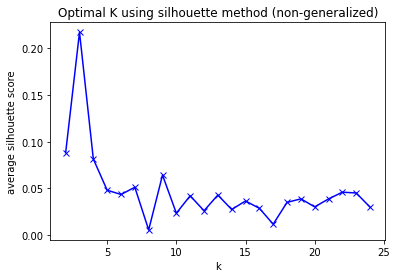

In [106]:
# Now we plot the silhouette scores and find the optimal value
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('average silhouette score')
plt.title('Optimal K using silhouette method (non-generalized)')
plt.show()

According to the silhouette score, k=3 appears to be optimal for this case.

In [112]:
# Train the KMeans model with k=3
km = KMeans(n_clusters=3)
km = km.fit(df_ml)
km.labels_

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [113]:
world_clustered = cities_df.join(pd.DataFrame(km.labels_,columns=['Cluster']))

Now we will map the cities and show their cluster.

In [114]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [115]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(7)
ys = [i + x + (i*x)**2 for i in range(7)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(world_clustered['Latitude'], world_clustered['Longitude'], world_clustered['City'], world_clustered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Exploratory Analysis - Set 2: Generalized Venue Categories

We will perform the same analysis as before between three cities on different continents.

In [116]:
world_grouped_general = world_grouped_general.reset_index()
tokyo = world_grouped_general.loc[world_grouped_general['City'] == 'Tokyo']
london = world_grouped_general.loc[world_grouped_general['City'] == 'London']
des = world_grouped_general.loc[world_grouped_general['City'] == 'Dar es Salaam']
df = tokyo.append(london).append(des)
#drop column if all values are 0
df = df.loc[:, (df != 0).any(axis=0)]
df

,City,African Restaurant,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Tea Room,Thai Restaurant,Theme Restaurant,Toy / Game Store,Trail,Train Station
33,Tokyo,0,1,2,0,0,0,1,3,13,...,0,2,2,1,1,1,1,0,5,2
18,London,0,0,0,1,2,0,0,10,15,...,0,0,0,5,0,0,0,3,0,0
5,Dar es Salaam,4,2,0,0,4,2,9,0,4,...,2,0,0,0,0,0,0,0,0,0


There are now 89 categories versus 126 in the non-generalized set

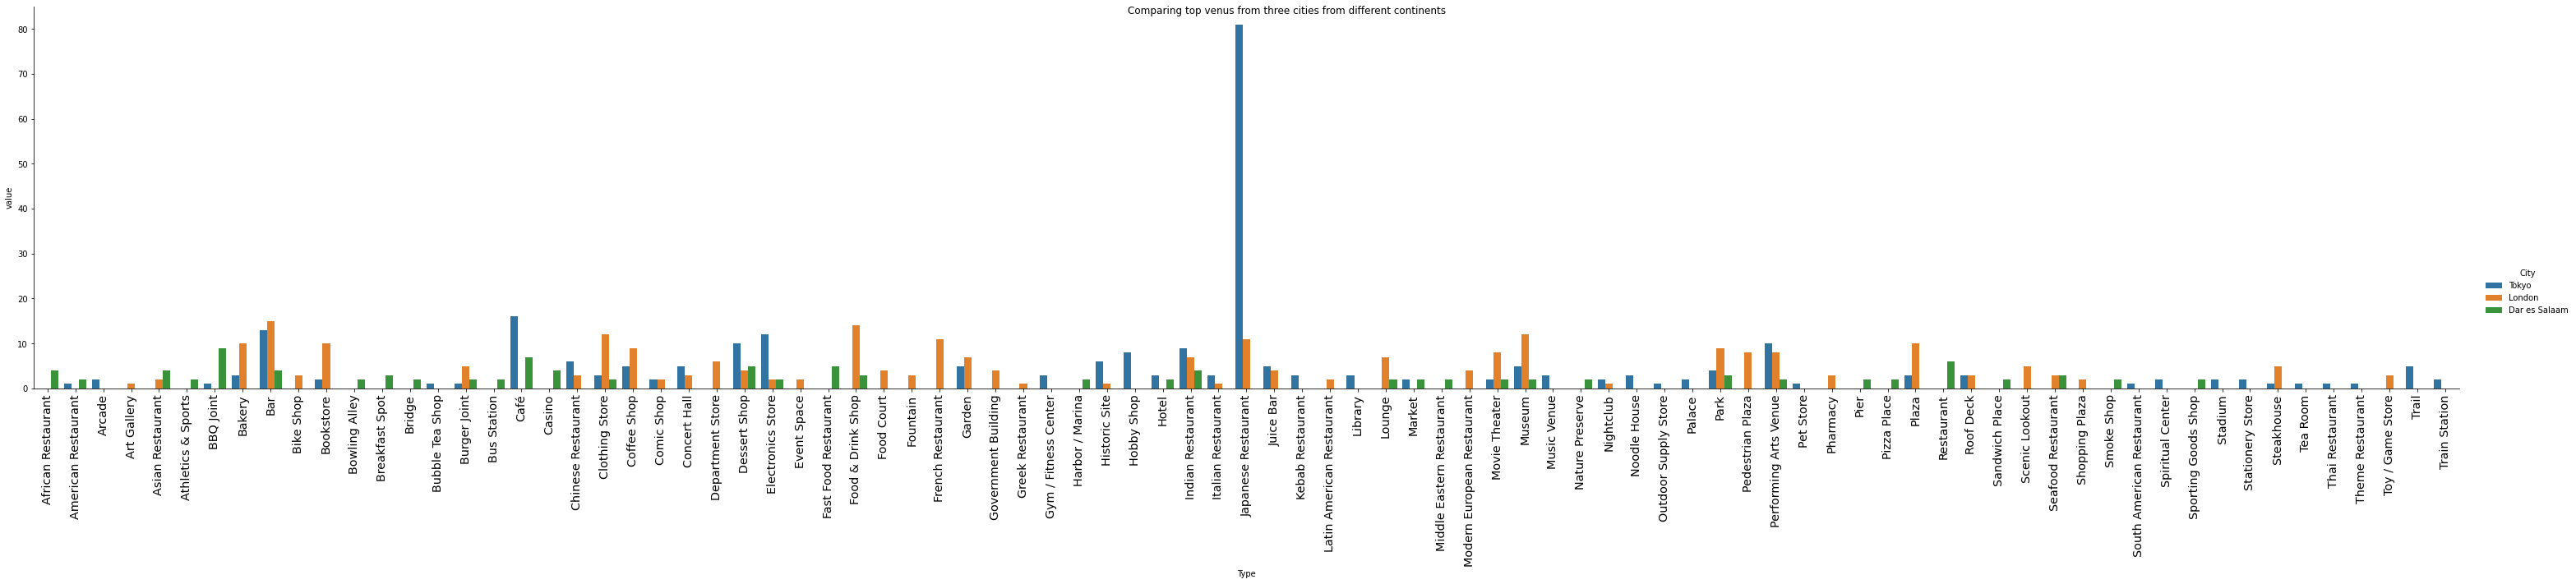

In [117]:
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus from three cities from different continents')

Now we will compare Buenos Aires and Lima

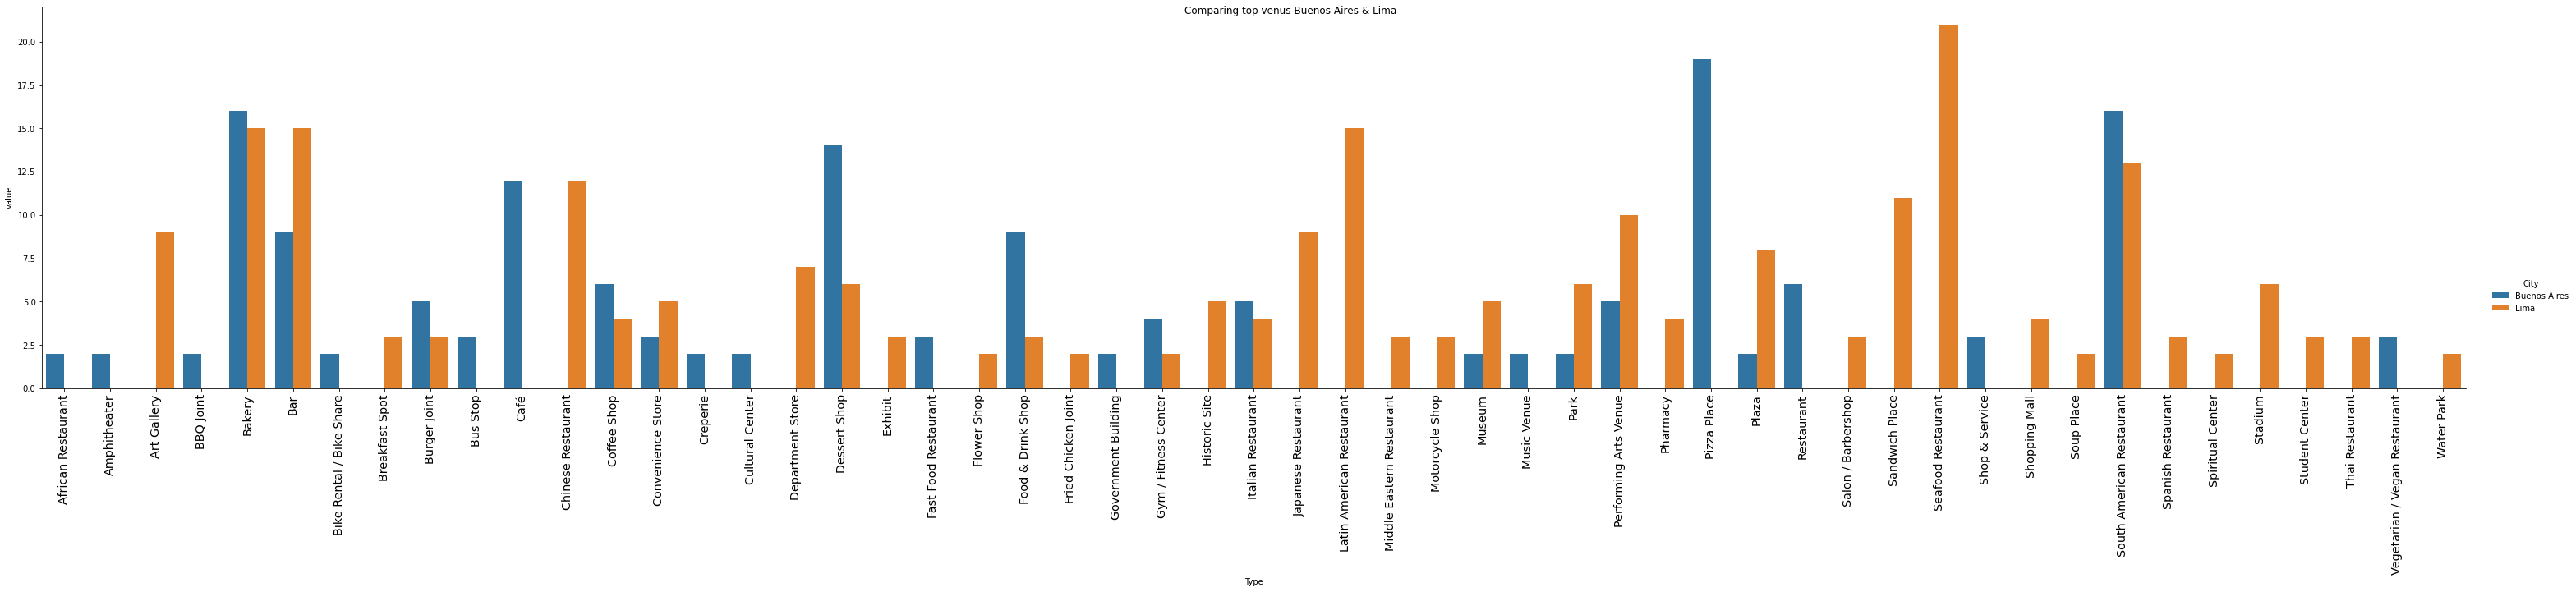

In [118]:
ba = world_grouped_general.loc[world_grouped_general['City'] == 'Buenos Aires']
s = world_grouped_general.loc[world_grouped_general['City'] == 'Lima']
df = ba.append(s)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus Buenos Aires & Lima')

And finally, Madrid and Shanghai

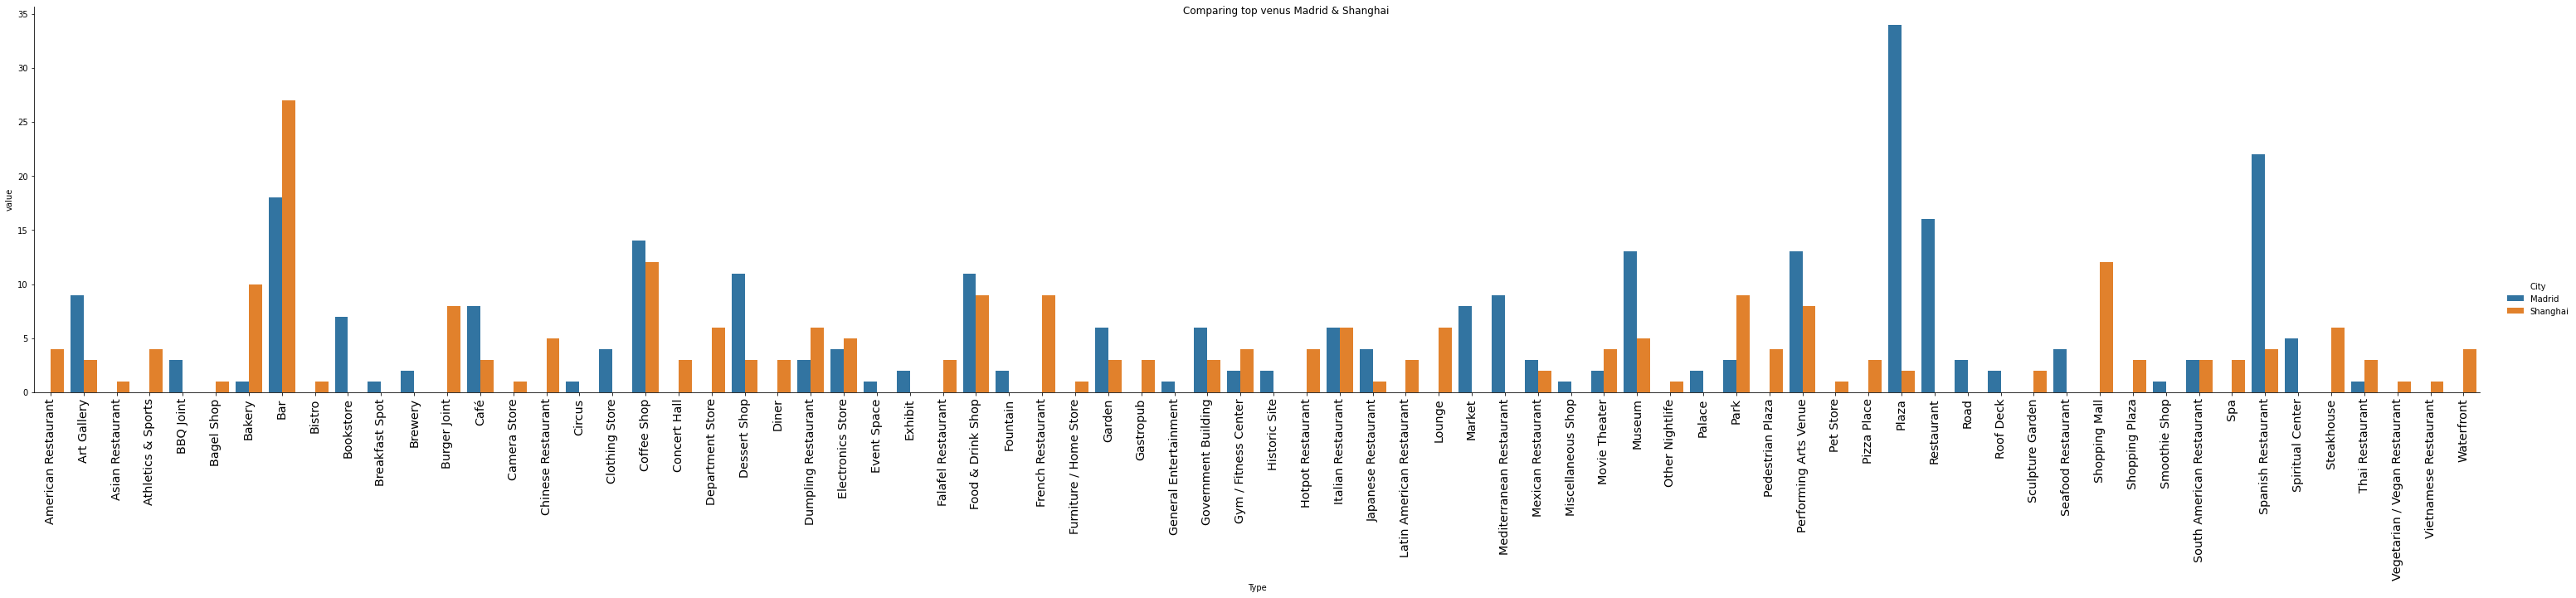

In [119]:
ba = world_grouped_general.loc[world_grouped_general['City'] == 'Madrid']
s = world_grouped_general.loc[world_grouped_general['City'] == 'Shanghai']
df = ba.append(s)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.reset_index(drop=True)
# Melt dataframe into a usable state for plotting as bar chart
df_plot = df.melt(id_vars=['City'],value_vars=df.columns[1:],var_name='Type')
fg = sns.catplot(x='Type',y='value', hue='City',data=df_plot, kind='bar',height=7,aspect = 6)
_ = fg.set_xticklabels(rotation=90, fontsize='x-large')
_ = fg.fig.suptitle('Comparing top venus Madrid & Shanghai')

# K-Means Clustering - Set 2: Generalized Venue Categories

In [120]:
# Get percentages for each venue type in each city
df_ml = world_onehot_general.groupby('City').mean().reset_index()
df_ml = df_ml.drop('City',1)
df_ml

,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,University,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wings Joint
0,0.000000,0.000000,0.000000,0.027586,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.003401,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006803,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.003413,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.003413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006826,0.000000,0.010239
3,0.000000,0.012270,0.000000,0.000000,0.01227,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.018405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011070,0.000000
5,0.000000,0.037037,0.000000,0.018519,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033088,0.000000,0.000000,0.136029,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.061818,0.000000,...,0.000000,0.000000,0.007273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
# using the intertia attribute of the Kmeans object, we can find the optimal K
ssd = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ml)
    ssd.append(km.inertia_)

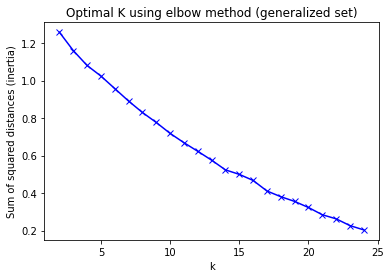

In [122]:
# Now we plot the sum of squared distances (inertia) and find the elbow
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances (inertia)')
plt.title('Optimal K using elbow method (generalized set)')
plt.show()

In [140]:
ss = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_ml)
    
    s_avg = metrics.silhouette_score(df_ml, km.labels_)
    print("For K clusters:", k, "The average silhouette score is:", s_avg)
    ss.append(s_avg)

For K clusters: 2 The average silhouette score is: 0.03872418288155005
For K clusters: 3 The average silhouette score is: 0.0626838584517417
For K clusters: 4 The average silhouette score is: 0.01698750186310792
For K clusters: 5 The average silhouette score is: 0.04046928707064387
For K clusters: 6 The average silhouette score is: 0.04957553862649769
For K clusters: 7 The average silhouette score is: 0.036980949911028474
For K clusters: 8 The average silhouette score is: 0.04386829208779272
For K clusters: 9 The average silhouette score is: 0.04485303826808278
For K clusters: 10 The average silhouette score is: 0.046014302886012735
For K clusters: 11 The average silhouette score is: 0.06356621076962468
For K clusters: 12 The average silhouette score is: 0.04425678081019033
For K clusters: 13 The average silhouette score is: 0.049405113507311235
For K clusters: 14 The average silhouette score is: 0.04753281757868702
For K clusters: 15 The average silhouette score is: 0.0434034728829144

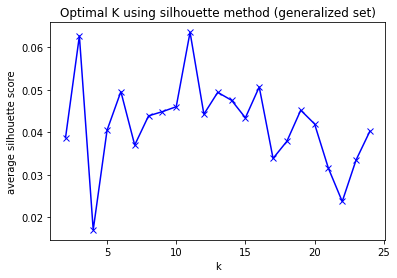

In [141]:
# Now we plot the silhouette scores and find the optimal value
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('average silhouette score')
plt.title('Optimal K using silhouette method (generalized set)')
plt.show()

Average Silhouette score shows the 5 is the optimal K

In [142]:
# Train the KMeans model with k=11
km = KMeans(n_clusters=11)
km = km.fit(df_ml)
km.labels_

array([ 3,  1,  3,  3,  2,  3,  7,  8,  0,  2,  2,  2,  3,  3,  3,  2,  9,
        0,  0,  5,  0,  3,  0,  0,  0,  0,  2, 10,  0,  0,  6,  0,  2,  4,
        0,  3])

In [143]:
world_clustered_general = cities_df.join(pd.DataFrame(km.labels_,columns=['Cluster']))

In [144]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(12)
ys = [i + x + (i*x)**2 for i in range(12)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(world_clustered_general['Latitude'], world_clustered_general['Longitude'], world_clustered_general['City'], world_clustered_general['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysis of Clusters

We will get the top three venues for each city, with their clusters.

In [199]:
final_df = world_clustered.copy()
final_df = final_df.drop(columns=['Area','Latitude','Longitude','Radius'])
final_df.rename(columns={'Cluster':'Cluster_NG'},inplace=True)
final_df['Cluster_G'] = world_clustered_general['Cluster']

In [200]:
# Get top three venues for each city and attach to the final dataframe
t=world_grouped.set_index('City').T

temp = pd.DataFrame(np.zeros((0,3)), columns=['top1_NG','top2_NG','top3_NG'])
for i in t.columns:
    df1row = pd.DataFrame(t.nlargest(3, i).index.tolist(), index=['top1_NG','top2_NG','top3_NG']).T
    df1row['City'] = i
    temp = pd.concat([temp, df1row], axis=0)
temp = temp.set_index('City')
final_df = final_df.join(temp,on='City')

run again to add the generalized set's top venues

In [201]:
# Get top three venues for each city and attach to the final dataframe
t=world_grouped_general.set_index('City').T

temp = pd.DataFrame(np.zeros((0,3)), columns=['top1_G','top2_G','top3_G'])
for i in t.columns:
    df1row = pd.DataFrame(t.nlargest(3, i).index.tolist(), index=['top1_G','top2_G','top3_G']).T
    df1row['City'] = i
    temp = pd.concat([temp, df1row], axis=0)
temp = temp.set_index('City')
final_df = final_df.join(temp,on='City')

In [203]:
# Reorganize the columns for readability
final_df = final_df[['City','Country','top1_NG','top2_NG','top3_NG','Cluster_NG','top1_G','top2_G','top3_G','Cluster_G']]

,City,Country,top1_NG,top2_NG,top3_NG,Cluster_NG,top1_G,top2_G,top3_G,Cluster_G
0,Tokyo,Japan,Japanese Curry Restaurant,Café,Ramen Restaurant,1,Japanese Restaurant,Café,Bar,3
1,Delhi,India,Indian Restaurant,Café,Snack Place,0,Indian Restaurant,Café,Snack Place,1
2,Seoul,South Korea,Korean Restaurant,Coffee Shop,Chinese Restaurant,0,Korean Restaurant,Coffee Shop,Japanese Restaurant,3
3,Shanghai,China,Coffee Shop,Shopping Mall,Cocktail Bar,0,Bar,Coffee Shop,Shopping Mall,3
4,São Paulo,Brazil,Bakery,Bar,Coffee Shop,1,Food & Drink Shop,Bar,Bakery,2
5,Mexico City,Mexico,Mexican Restaurant,Bakery,Taco Place,0,Mexican Restaurant,Museum,Bakery,3
6,Cairo,Egypt,Café,Coffee Shop,Lounge,0,Café,Middle Eastern Restaurant,Coffee Shop,7
7,Dhaka,Bangladesh,Café,Bar,Nightclub,1,Bar,Café,Athletics & Sports,8
8,New York,United States,Park,Coffee Shop,Bakery,0,Park,Coffee Shop,Bar,0
9,Karachi,Pakistan,Fast Food Restaurant,Market,Asian Restaurant,1,Fast Food Restaurant,Market,Asian Restaurant,2


In [204]:
final_df.head()

,City,Country,top1_NG,top2_NG,top3_NG,Cluster_NG,top1_G,top2_G,top3_G,Cluster_G
0,Tokyo,Japan,Japanese Curry Restaurant,Café,Ramen Restaurant,1,Japanese Restaurant,Café,Bar,3
1,Delhi,India,Indian Restaurant,Café,Snack Place,0,Indian Restaurant,Café,Snack Place,1
2,Seoul,South Korea,Korean Restaurant,Coffee Shop,Chinese Restaurant,0,Korean Restaurant,Coffee Shop,Japanese Restaurant,3
3,Shanghai,China,Coffee Shop,Shopping Mall,Cocktail Bar,0,Bar,Coffee Shop,Shopping Mall,3
4,São Paulo,Brazil,Bakery,Bar,Coffee Shop,1,Food & Drink Shop,Bar,Bakery,2


In [205]:
df_ml['Seafood Restaurant']

0     0.000000
1     0.017007
2     0.044369
3     0.000000
4     0.014760
5     0.027778
6     0.000000
7     0.000000
8     0.058824
9     0.000000
10    0.027132
11    0.011905
12    0.024793
13    0.010526
14    0.000000
15    0.000000
16    0.000000
17    0.088983
18    0.012000
19    0.000000
20    0.014599
21    0.000000
22    0.038194
23    0.010601
24    0.017794
25    0.013605
26    0.010169
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.010381
32    0.012245
33    0.000000
34    0.000000
35    0.000000
Name: Seafood Restaurant, dtype: float64

In [207]:
world_grouped[world_grouped['City']=='Lima']['Seafood Restaurant']

17    21
Name: Seafood Restaurant, dtype: uint8

In [208]:
world_grouped_general[world_grouped_general['City']=='Paris']['French Restaurant']

25    50
Name: French Restaurant, dtype: uint8